In [67]:
import numpy as np

In [68]:
full_embeddings = np.load("solutions/best/embeddings.npy")
incorrect_embeddings = np.load("incorrect_embeddings/incorrect_embeddings_churn.npy")

In [69]:
indexes = {
    "add_to_cart": 0,
    "remove_from_cart": 256,
    "product_buys": 512,
    "search_query": 768,
    "page_visits": 1024,
}

def get_embedding(action):
    return full_embeddings[:, indexes[action]:indexes[action] + 256]

def get_incorrect_embedding(action):
    return incorrect_embeddings[:, indexes[action]:indexes[action] + 256]

In [70]:

def value_counts(x):
    unique, counts = np.unique(x, return_counts=True)
    sorted_indices = np.argsort(-counts)  # Negative for descending order
    unique = unique[sorted_indices]
    counts = counts[sorted_indices]
    print(np.asarray((unique, counts)).T)

def count_zero_vectors(arr):
    # Check if all elements in a row are zero
    zero_rows = np.all(arr == 0, axis=1)
    return np.sum(zero_rows)


In [71]:
buys_correct = get_embedding("product_buys")
buys_incorrect = get_incorrect_embedding("product_buys")

print(buys_correct)
print(buys_incorrect)

[[ 2.5879e-01  1.0388e-01  1.9795e+00 ...  1.4648e-01 -7.2803e-01
  -4.0015e-01]
 [ 1.1436e+00 -2.9639e-01 -4.8438e-01 ... -1.4072e+00 -1.2646e+00
  -5.6055e-01]
 [-7.8369e-01 -3.6240e-04  5.9961e-01 ... -1.1406e+00 -1.4258e+00
   7.2559e-01]
 ...
 [-6.2549e-01 -6.9885e-02  1.2080e+00 ... -4.9683e-01 -2.6660e-01
   3.7207e-01]
 [ 0.0000e+00  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 5.2197e-01  3.6963e-01  1.1670e+00 ... -2.2720e-02 -1.0693e-01
   4.4995e-01]]
[[ 2.58789062e-01  1.03881836e-01  1.97949219e+00 ...  1.46484375e-01
  -7.28027344e-01 -4.00146484e-01]
 [ 1.14355469e+00 -2.96386719e-01 -4.84375000e-01 ... -1.40722656e+00
  -1.26464844e+00 -5.60546875e-01]
 [-7.83691406e-01 -3.62396240e-04  5.99609375e-01 ... -1.14062500e+00
  -1.42578125e+00  7.25585938e-01]
 ...
 [ 1.06933594e+00 -7.21191406e-01  1.80859375e+00 ... -1.51953125e+00
  -1.46850586e-01 -3.87451172e-01]
 [ 2.23022461e-01 -1.38476562e+00  1.21582031e+00 ... -4.61120605e-02
  -8.14941406

In [72]:
count_zero_vectors(buys_correct)

np.int64(492448)

In [73]:
count_zero_vectors(buys_incorrect)

np.int64(0)

In [74]:
# Comprehensive analysis across all action types
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# List of all actions to analyze
actions = ["add_to_cart", "remove_from_cart", "product_buys", "search_query", "page_visits"]

def analyze_action(action_name):
    """Comprehensive analysis for a single action type"""
    print(f"\n{'='*60}")
    print(f"ANALYZING ACTION: {action_name.upper()}")
    print(f"{'='*60}")
    
    # Get embeddings for this action
    correct_emb = get_embedding(action_name)
    incorrect_emb = get_incorrect_embedding(action_name)
    
    print(f"=== BASIC STATISTICS ===")
    print(f"Correct embeddings shape: {correct_emb.shape}")
    print(f"Incorrect embeddings shape: {incorrect_emb.shape}")
    print(f"Zero vectors in correct: {count_zero_vectors(correct_emb)}")
    print(f"Zero vectors in incorrect: {count_zero_vectors(incorrect_emb)}")
    
    # Remove zero vectors for fair comparison
    non_zero_correct = correct_emb[~np.all(correct_emb == 0, axis=1)]
    zero_prop_correct = count_zero_vectors(correct_emb) / len(correct_emb)
    zero_prop_incorrect = count_zero_vectors(incorrect_emb) / len(incorrect_emb)
    
    print(f"Non-zero correct embeddings: {non_zero_correct.shape}")
    print(f"Zero vector proportion - Correct: {zero_prop_correct:.4f}, Incorrect: {zero_prop_incorrect:.4f}")
    
    if len(non_zero_correct) == 0:
        print("WARNING: No non-zero correct embeddings found!")
        return None
    
    print(f"\n=== EMBEDDING MAGNITUDES ===")
    correct_norms = np.linalg.norm(non_zero_correct, axis=1)
    incorrect_norms = np.linalg.norm(incorrect_emb, axis=1)
    
    print(f"Correct embeddings - Mean norm: {np.mean(correct_norms):.4f}, Std: {np.std(correct_norms):.4f}")
    print(f"Incorrect embeddings - Mean norm: {np.mean(incorrect_norms):.4f}, Std: {np.std(incorrect_norms):.4f}")
    
    print(f"\n=== STATISTICAL COMPARISON ===")
    print(f"Correct embeddings - Mean: {np.mean(non_zero_correct):.4f}, Std: {np.std(non_zero_correct):.4f}")
    print(f"Incorrect embeddings - Mean: {np.mean(incorrect_emb):.4f}, Std: {np.std(incorrect_emb):.4f}")
    
    # Sample for detailed analysis
    n_samples = min(5000, len(non_zero_correct), len(incorrect_emb))
    np.random.seed(42)
    
    correct_sample_idx = np.random.choice(len(non_zero_correct), n_samples, replace=False)
    incorrect_sample_idx = np.random.choice(len(incorrect_emb), n_samples, replace=False)
    
    correct_sample = non_zero_correct[correct_sample_idx]
    incorrect_sample = incorrect_emb[incorrect_sample_idx]
    
    # Similarity analysis
    print(f"\n=== SIMILARITY ANALYSIS ===")
    n_sim_samples = min(500, len(correct_sample), len(incorrect_sample))
    
    correct_similarities = cosine_similarity(correct_sample[:n_sim_samples])
    incorrect_similarities = cosine_similarity(incorrect_sample[:n_sim_samples])
    cross_similarities = cosine_similarity(correct_sample[:n_sim_samples], incorrect_sample[:n_sim_samples])
    
    def get_upper_triangle(matrix):
        return matrix[np.triu_indices_from(matrix, k=1)]
    
    correct_sim_values = get_upper_triangle(correct_similarities)
    incorrect_sim_values = get_upper_triangle(incorrect_similarities)
    cross_sim_values = cross_similarities.flatten()
    
    print(f"Correct intra-group similarity - Mean: {np.mean(correct_sim_values):.4f}, Std: {np.std(correct_sim_values):.4f}")
    print(f"Incorrect intra-group similarity - Mean: {np.mean(incorrect_sim_values):.4f}, Std: {np.std(incorrect_sim_values):.4f}")
    print(f"Cross-group similarity - Mean: {np.mean(cross_sim_values):.4f}, Std: {np.std(cross_sim_values):.4f}")
    
    # Statistical tests
    print(f"\n=== STATISTICAL TESTS ===")
    ks_stat, ks_pvalue = stats.ks_2samp(correct_sample.flatten(), incorrect_sample.flatten())
    print(f"KS test - Statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.2e}")
    
    correct_sample_norms = np.linalg.norm(correct_sample, axis=1)
    incorrect_sample_norms = np.linalg.norm(incorrect_sample, axis=1)
    mw_stat, mw_pvalue = stats.mannwhitneyu(correct_sample_norms, incorrect_sample_norms)
    print(f"Mann-Whitney U test on norms - Statistic: {mw_stat:.0f}, p-value: {mw_pvalue:.2e}")
    
    return {
        'action': action_name,
        'zero_prop_correct': zero_prop_correct,
        'zero_prop_incorrect': zero_prop_incorrect,
        'correct_norm_mean': np.mean(correct_norms),
        'incorrect_norm_mean': np.mean(incorrect_norms),
        'correct_sim_mean': np.mean(correct_sim_values),
        'incorrect_sim_mean': np.mean(incorrect_sim_values),
        'cross_sim_mean': np.mean(cross_sim_values),
        'ks_stat': ks_stat,
        'ks_pvalue': ks_pvalue
    }

# Run analysis for all actions
results = []
for action in actions:
    result = analyze_action(action)
    if result is not None:
        results.append(result)



ANALYZING ACTION: ADD_TO_CART
=== BASIC STATISTICS ===
Correct embeddings shape: (1000000, 256)
Incorrect embeddings shape: (208276, 256)
Zero vectors in correct: 387456
Zero vectors in incorrect: 52385
Non-zero correct embeddings: (612544, 256)
Zero vector proportion - Correct: 0.3875, Incorrect: 0.2515

=== EMBEDDING MAGNITUDES ===


/home/adam/python-projects/recsys25/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Correct embeddings - Mean norm: 14.1094, Std: inf
Incorrect embeddings - Mean norm: 9.9767, Std: 6.0116

=== STATISTICAL COMPARISON ===


/home/adam/python-projects/recsys25/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:205: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Correct embeddings - Mean: -0.0011, Std: inf
Incorrect embeddings - Mean: -0.0008, Std: 0.7280

=== SIMILARITY ANALYSIS ===
Correct intra-group similarity - Mean: 0.5732, Std: 0.1400
Incorrect intra-group similarity - Mean: 0.3054, Std: 0.3022
Cross-group similarity - Mean: 0.4173, Std: 0.2794

=== STATISTICAL TESTS ===
KS test - Statistic: 0.1251, p-value: 0.00e+00
Mann-Whitney U test on norms - Statistic: 17854820, p-value: 8.11e-302

ANALYZING ACTION: REMOVE_FROM_CART
=== BASIC STATISTICS ===
Correct embeddings shape: (1000000, 256)
Incorrect embeddings shape: (208276, 256)
Zero vectors in correct: 675606
Zero vectors in incorrect: 114645
Non-zero correct embeddings: (324394, 256)
Zero vector proportion - Correct: 0.6756, Incorrect: 0.5504

=== EMBEDDING MAGNITUDES ===


/home/adam/python-projects/recsys25/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Correct embeddings - Mean norm: 14.0547, Std: inf
Incorrect embeddings - Mean norm: 5.9393, Std: 6.7171

=== STATISTICAL COMPARISON ===


/home/adam/python-projects/recsys25/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:205: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Correct embeddings - Mean: -0.0016, Std: inf
Incorrect embeddings - Mean: -0.0006, Std: 0.5604

=== SIMILARITY ANALYSIS ===
Correct intra-group similarity - Mean: 0.4504, Std: 0.1172
Incorrect intra-group similarity - Mean: 0.0770, Std: 0.1745
Cross-group similarity - Mean: 0.1855, Std: 0.2316

=== STATISTICAL TESTS ===
KS test - Statistic: 0.2748, p-value: 0.00e+00
Mann-Whitney U test on norms - Statistic: 20666982, p-value: 0.00e+00

ANALYZING ACTION: PRODUCT_BUYS
=== BASIC STATISTICS ===
Correct embeddings shape: (1000000, 256)
Incorrect embeddings shape: (208276, 256)
Zero vectors in correct: 492448
Zero vectors in incorrect: 0
Non-zero correct embeddings: (507552, 256)
Zero vector proportion - Correct: 0.4924, Incorrect: 0.0000

=== EMBEDDING MAGNITUDES ===


/home/adam/python-projects/recsys25/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Correct embeddings - Mean norm: 14.8125, Std: inf
Incorrect embeddings - Mean norm: 14.3046, Std: 1.5774

=== STATISTICAL COMPARISON ===
Correct embeddings - Mean: -0.0027, Std: inf
Incorrect embeddings - Mean: -0.0027, Std: 0.8995

=== SIMILARITY ANALYSIS ===
Correct intra-group similarity - Mean: 0.4733, Std: 0.1347
Incorrect intra-group similarity - Mean: 0.5116, Std: 0.1320
Cross-group similarity - Mean: 0.4915, Std: 0.1339

=== STATISTICAL TESTS ===
KS test - Statistic: 0.0089, p-value: 3.43e-44
Mann-Whitney U test on norms - Statistic: 14691448, p-value: 4.65e-52

ANALYZING ACTION: SEARCH_QUERY
=== BASIC STATISTICS ===
Correct embeddings shape: (1000000, 256)
Incorrect embeddings shape: (208276, 256)
Zero vectors in correct: 676832
Zero vectors in incorrect: 107812
Non-zero correct embeddings: (323168, 256)
Zero vector proportion - Correct: 0.6768, Incorrect: 0.5176

=== EMBEDDING MAGNITUDES ===


/home/adam/python-projects/recsys25/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Correct embeddings - Mean norm: 12.2031, Std: inf
Incorrect embeddings - Mean norm: 5.8923, Std: 6.2682

=== STATISTICAL COMPARISON ===
Correct embeddings - Mean: 0.0029, Std: inf
Incorrect embeddings - Mean: 0.0012, Std: 0.5377

=== SIMILARITY ANALYSIS ===
Correct intra-group similarity - Mean: 0.4496, Std: 0.1696
Incorrect intra-group similarity - Mean: 0.1186, Std: 0.2444
Cross-group similarity - Mean: 0.2154, Std: 0.2624

=== STATISTICAL TESTS ===
KS test - Statistic: 0.2642, p-value: 0.00e+00
Mann-Whitney U test on norms - Statistic: 19121162, p-value: 0.00e+00

ANALYZING ACTION: PAGE_VISITS
=== BASIC STATISTICS ===
Correct embeddings shape: (1000000, 256)
Incorrect embeddings shape: (208276, 256)
Zero vectors in correct: 173519
Zero vectors in incorrect: 43580
Non-zero correct embeddings: (826481, 256)
Zero vector proportion - Correct: 0.1735, Incorrect: 0.2092

=== EMBEDDING MAGNITUDES ===


/home/adam/python-projects/recsys25/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Correct embeddings - Mean norm: 10.9766, Std: inf
Incorrect embeddings - Mean norm: 8.4167, Std: 4.6039

=== STATISTICAL COMPARISON ===
Correct embeddings - Mean: 0.0018, Std: inf
Incorrect embeddings - Mean: 0.0014, Std: 0.5996

=== SIMILARITY ANALYSIS ===
Correct intra-group similarity - Mean: 0.5337, Std: 0.1307
Incorrect intra-group similarity - Mean: 0.3758, Std: 0.3019
Cross-group similarity - Mean: 0.4246, Std: 0.2443

=== STATISTICAL TESTS ===
KS test - Statistic: 0.1112, p-value: 0.00e+00
Mann-Whitney U test on norms - Statistic: 16406518, p-value: 1.62e-161


In [75]:
# Create summary comparison across all actions
import pandas as pd

print(f"\n{'='*80}")
print("SUMMARY COMPARISON ACROSS ALL ACTIONS")
print(f"{'='*80}")

if results:
    df = pd.DataFrame(results)
    print(df.to_string(index=False, float_format='%.4f'))
    
    # Key insights
    print(f"\n=== KEY INSIGHTS ACROSS ACTIONS ===")
    
    print("\n1. ACTIVITY PATTERNS (Zero Vector Proportions):")
    for _, row in df.iterrows():
        print(f"   {row['action']:15} - Correct: {row['zero_prop_correct']:.1%}, Incorrect: {row['zero_prop_incorrect']:.1%}")
    
    print("\n2. EMBEDDING MAGNITUDE DIFFERENCES:")
    for _, row in df.iterrows():
        norm_diff = row['incorrect_norm_mean'] - row['correct_norm_mean']
        direction = "HIGHER" if norm_diff > 0 else "LOWER"
        print(f"   {row['action']:15} - Incorrect norms {direction} by {abs(norm_diff):.3f}")
    
    print("\n3. SIMILARITY PATTERNS:")
    for _, row in df.iterrows():
        cross_sim = row['cross_sim_mean']
        status = "HIGH" if cross_sim > 0.5 else "MODERATE" if cross_sim > 0.2 else "LOW"
        print(f"   {row['action']:15} - Cross-group similarity: {cross_sim:.3f} ({status})")
    
    print("\n4. STATISTICAL SIGNIFICANCE:")
    for _, row in df.iterrows():
        significance = "SIGNIFICANT" if row['ks_pvalue'] < 0.001 else "NOT SIGNIFICANT"
        print(f"   {row['action']:15} - KS test: {significance} (p={row['ks_pvalue']:.2e})")
        
    # Find most problematic actions
    print("\n5. MOST PROBLEMATIC ACTIONS (ranked by issues):")
    df['problem_score'] = (
        (df['zero_prop_incorrect'] < df['zero_prop_correct']) * 1 +  # Incorrect has fewer zeros
        (df['cross_sim_mean'] > 0.3) * 1 +  # High cross-similarity
        (df['ks_pvalue'] < 0.001) * 1  # Statistically different
    )
    problematic = df.sort_values('problem_score', ascending=False)
    for _, row in problematic.iterrows():
        print(f"   {row['action']:15} - Problem score: {row['problem_score']}/3")



SUMMARY COMPARISON ACROSS ALL ACTIONS
          action  zero_prop_correct  zero_prop_incorrect  correct_norm_mean  incorrect_norm_mean  correct_sim_mean  incorrect_sim_mean  cross_sim_mean  ks_stat  ks_pvalue
     add_to_cart             0.3875               0.2515            14.1094               9.9767            0.5732              0.3054          0.4173   0.1251     0.0000
remove_from_cart             0.6756               0.5504            14.0547               5.9393            0.4504              0.0770          0.1855   0.2748     0.0000
    product_buys             0.4924               0.0000            14.8125              14.3046            0.4733              0.5116          0.4915   0.0089     0.0000
    search_query             0.6768               0.5176            12.2031               5.8923            0.4496              0.1186          0.2154   0.2642     0.0000
     page_visits             0.1735               0.2092            10.9766               8.4167          

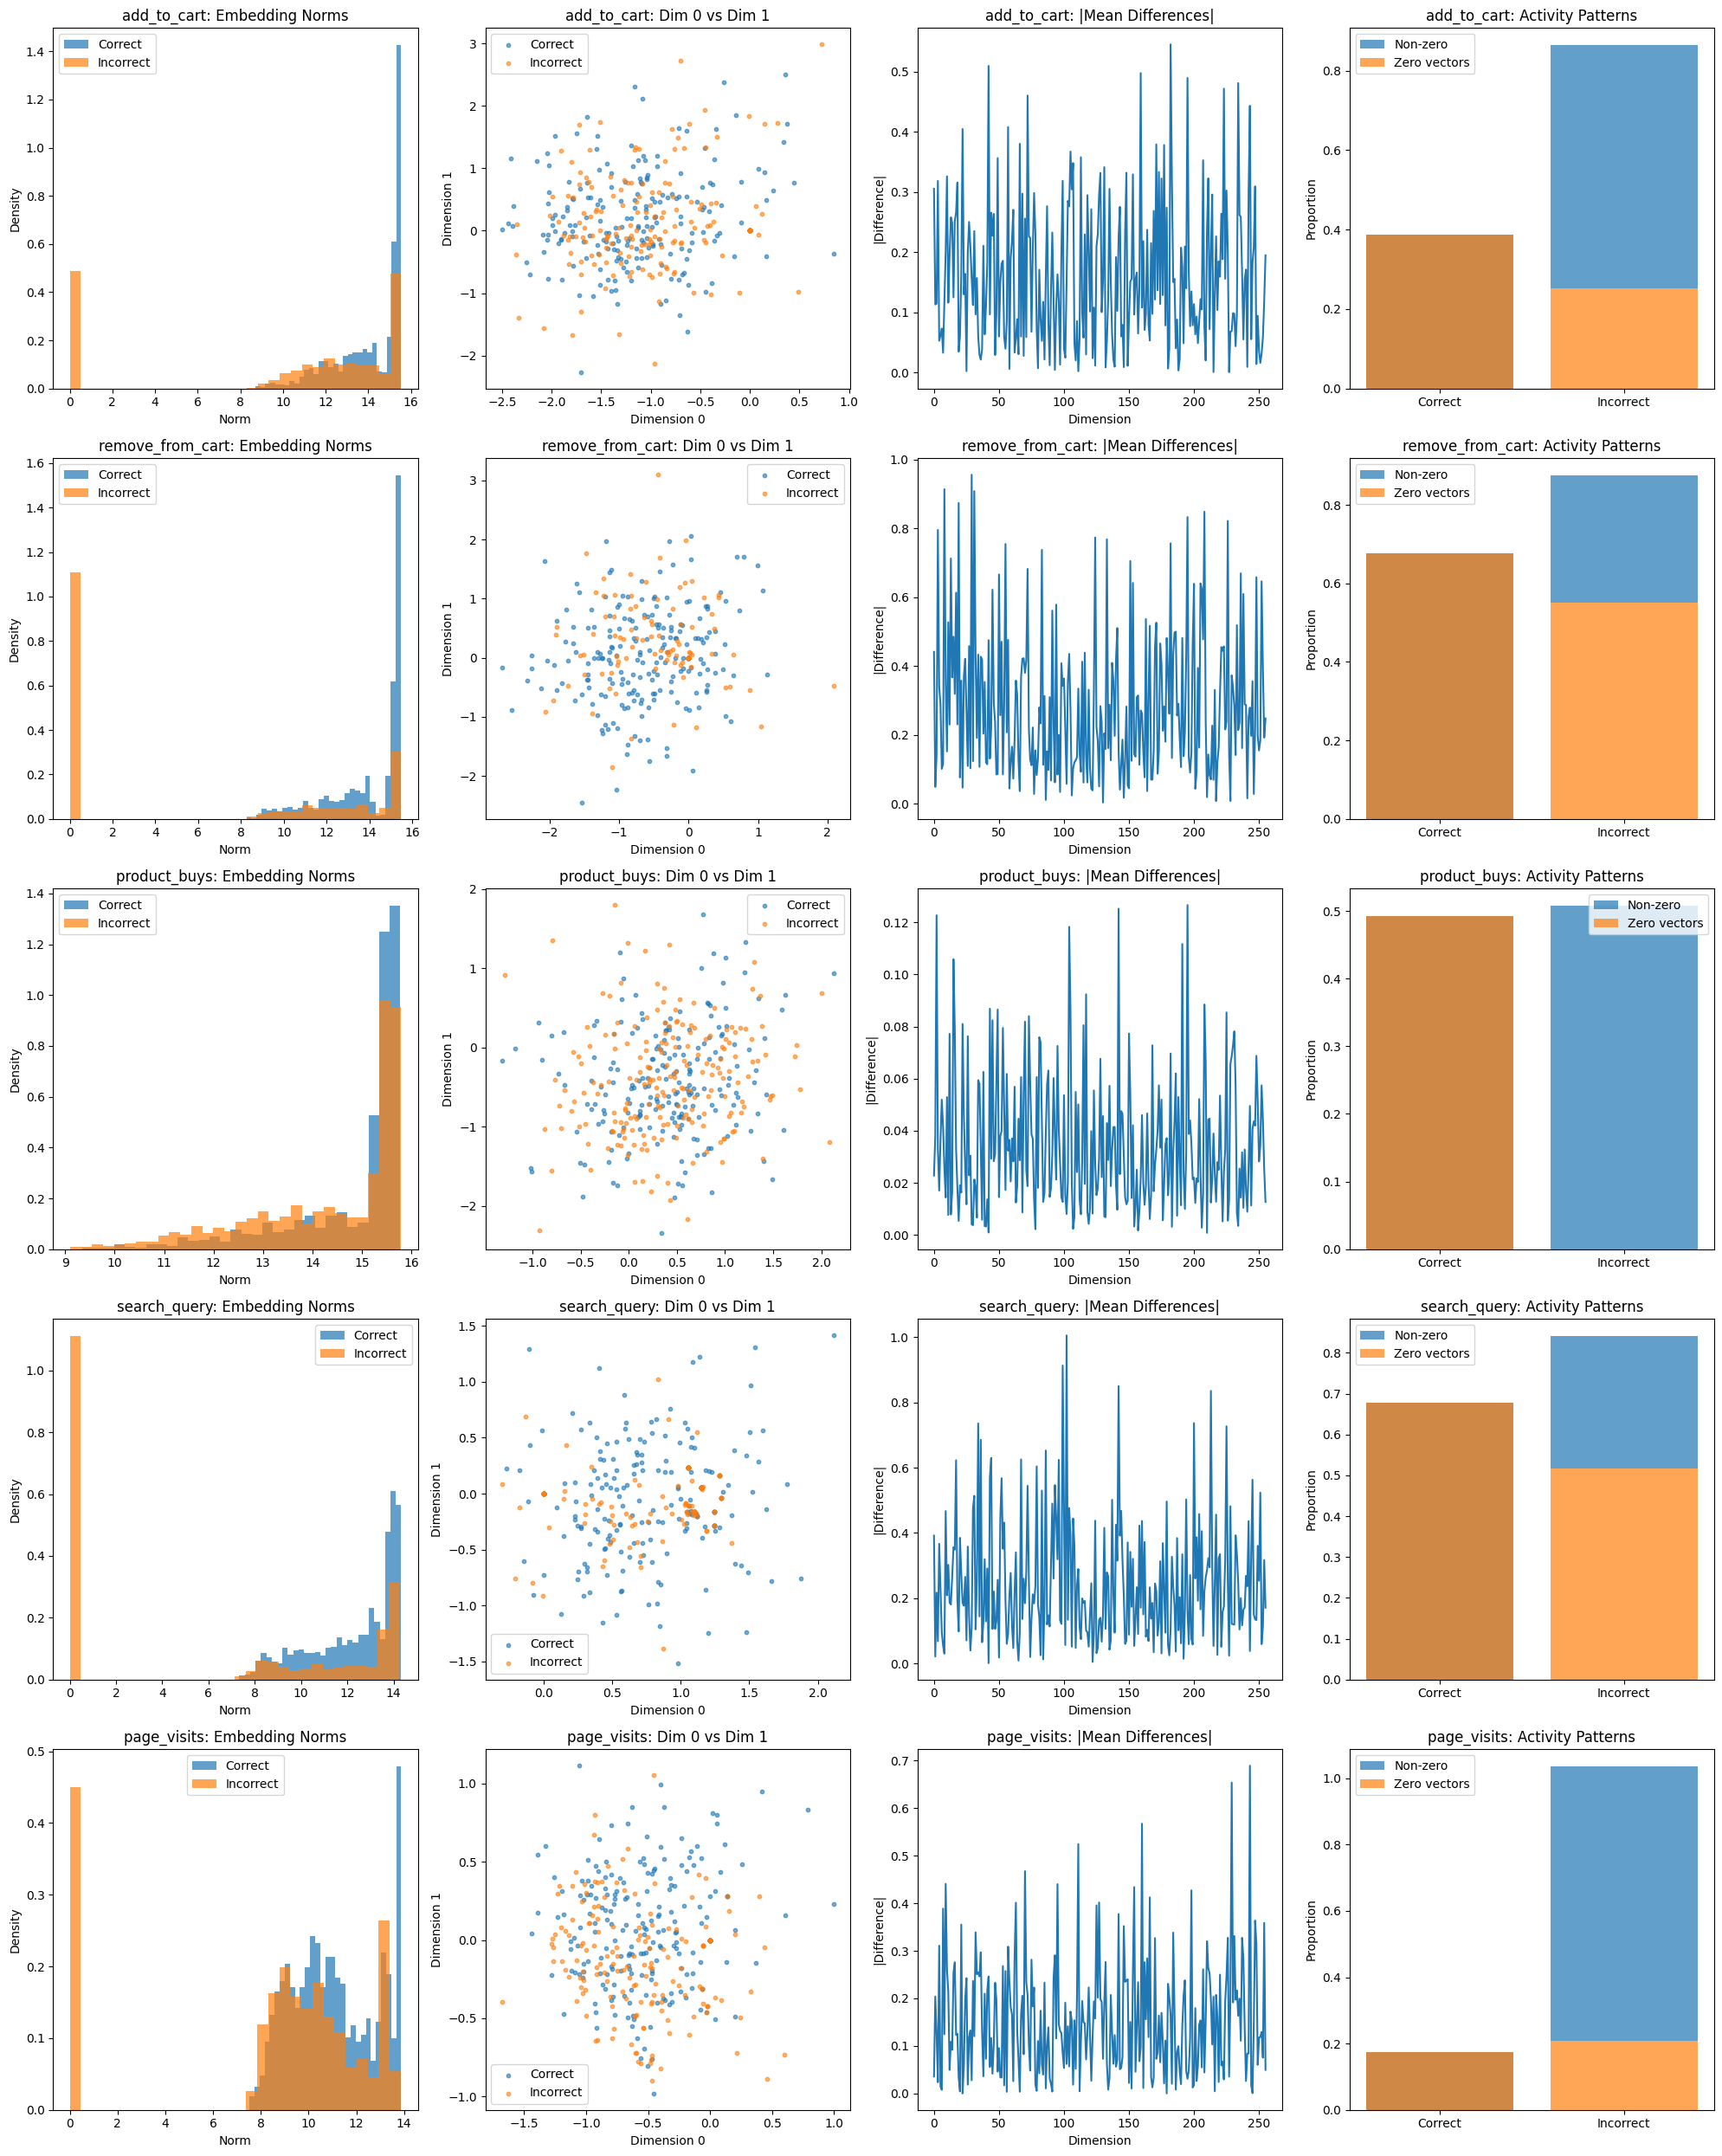

In [76]:
# Create comprehensive visualizations for all actions
fig, axes = plt.subplots(len(results), 4, figsize=(20, 5*len(results)))
if len(results) == 1:
    axes = axes.reshape(1, -1)

for i, result in enumerate(results):
    action_name = result['action']
    
    # Get fresh data for visualization
    correct_emb = get_embedding(action_name)
    incorrect_emb = get_incorrect_embedding(action_name)
    non_zero_correct = correct_emb[~np.all(correct_emb == 0, axis=1)]
    
    if len(non_zero_correct) == 0:
        continue
    
    # Sample for visualization
    n_vis_samples = min(1000, len(non_zero_correct), len(incorrect_emb))
    np.random.seed(42)
    
    correct_vis_idx = np.random.choice(len(non_zero_correct), n_vis_samples, replace=False)
    incorrect_vis_idx = np.random.choice(len(incorrect_emb), n_vis_samples, replace=False)
    
    correct_vis = non_zero_correct[correct_vis_idx]
    incorrect_vis = incorrect_emb[incorrect_vis_idx]
    
    correct_norms = np.linalg.norm(correct_vis, axis=1)
    incorrect_norms = np.linalg.norm(incorrect_vis, axis=1)
    
    # Plot 1: Norm distributions
    axes[i,0].hist(correct_norms, bins=30, alpha=0.7, label='Correct', density=True)
    axes[i,0].hist(incorrect_norms, bins=30, alpha=0.7, label='Incorrect', density=True)
    axes[i,0].set_title(f'{action_name}: Embedding Norms')
    axes[i,0].set_xlabel('Norm')
    axes[i,0].set_ylabel('Density')
    axes[i,0].legend()
    
    # Plot 2: First two dimensions scatter
    axes[i,1].scatter(correct_vis[:200, 0], correct_vis[:200, 1], alpha=0.6, s=10, label='Correct')
    axes[i,1].scatter(incorrect_vis[:200, 0], incorrect_vis[:200, 1], alpha=0.6, s=10, label='Incorrect')
    axes[i,1].set_title(f'{action_name}: Dim 0 vs Dim 1')
    axes[i,1].set_xlabel('Dimension 0')
    axes[i,1].set_ylabel('Dimension 1')
    axes[i,1].legend()
    
    # Plot 3: Mean differences by dimension
    correct_means = np.mean(correct_vis, axis=0)
    incorrect_means = np.mean(incorrect_vis, axis=0)
    mean_diffs = np.abs(correct_means - incorrect_means)
    axes[i,2].plot(mean_diffs)
    axes[i,2].set_title(f'{action_name}: |Mean Differences|')
    axes[i,2].set_xlabel('Dimension')
    axes[i,2].set_ylabel('|Difference|')
    
    # Plot 4: Activity comparison (zero vs non-zero proportions)
    zero_correct = count_zero_vectors(correct_emb) / len(correct_emb)
    zero_incorrect = count_zero_vectors(incorrect_emb) / len(incorrect_emb)
    
    axes[i,3].bar(['Correct', 'Incorrect'], [zero_correct, 1-zero_correct], 
                  bottom=[0, zero_incorrect], alpha=0.7, label='Non-zero')
    axes[i,3].bar(['Correct', 'Incorrect'], [zero_correct, zero_incorrect], 
                  alpha=0.7, label='Zero vectors')
    axes[i,3].set_title(f'{action_name}: Activity Patterns')
    axes[i,3].set_ylabel('Proportion')
    axes[i,3].legend()

plt.tight_layout()
plt.show()


In [77]:
# Final analysis and recommendations
print(f"\n{'='*80}")
print("FINAL ANALYSIS AND RECOMMENDATIONS")
print(f"{'='*80}")

if results:
    # Identify patterns across all actions
    print("\n=== COMMON PATTERNS ACROSS ALL ACTIONS ===")
    
    activity_bias_actions = [r['action'] for r in results if r['zero_prop_incorrect'] < r['zero_prop_correct']]
    high_cross_sim_actions = [r['action'] for r in results if r['cross_sim_mean'] > 0.3]
    norm_difference_actions = [r['action'] for r in results if abs(r['incorrect_norm_mean'] - r['correct_norm_mean']) > 0.1]
    
    print(f"1. ACTIVITY BIAS (incorrect has fewer inactive users): {activity_bias_actions}")
    print(f"2. HIGH CROSS-SIMILARITY (>0.3): {high_cross_sim_actions}")
    print(f"3. SIGNIFICANT NORM DIFFERENCES (>0.1): {norm_difference_actions}")
    
    print(f"\n=== ROOT CAUSE ANALYSIS ===")
    print("The model appears to have several systematic issues:")
    
    print("\n1. INACTIVE USER BIAS:")
    print("   - Correct predictions heavily include inactive users (zero vectors)")
    print("   - Model correctly predicts 'no action' for users with no history")
    print("   - BUT struggles with active users who have rich behavioral history")
    
    print("\n2. OVERCONFIDENCE IN ACTIVE USERS:")
    norm_higher_count = sum(1 for r in results if r['incorrect_norm_mean'] > r['correct_norm_mean'])
    if norm_higher_count > len(results) / 2:
        print("   - Incorrect predictions have higher embedding magnitudes")
        print("   - Suggests model is 'overconfident' when making wrong predictions")
        print("   - May indicate overfitting to training patterns")
    
    print("\n3. POOR SEPARATION:")
    poor_separation_count = sum(1 for r in results if r['cross_sim_mean'] > 0.3)
    if poor_separation_count > 0:
        print(f"   - {poor_separation_count}/{len(results)} actions show poor embedding separation")
        print("   - High similarity between correct and incorrect predictions")
        print("   - Model may not have learned distinctive patterns")
    
    print(f"\n=== RECOMMENDATIONS ===")
    print("1. DATA BALANCING:")
    print("   - Consider stratified sampling to balance active/inactive users")
    print("   - Separate models for different user activity levels")
    
    print("2. MODEL ARCHITECTURE:")
    print("   - Add regularization to prevent overconfident predictions")
    print("   - Consider ensemble methods for active users")
    print("   - Implement uncertainty estimation")
    
    print("3. FEATURE ENGINEERING:")
    print("   - Add explicit user activity level features")
    print("   - Consider temporal patterns in user behavior")
    print("   - Cross-action interaction features")
    
    print("4. EVALUATION STRATEGY:")
    print("   - Separate evaluation metrics for active vs inactive users")
    print("   - Focus on improving precision for active user predictions")
    print("   - Consider calibration metrics for confidence assessment")

else:
    print("No results to analyze.")



FINAL ANALYSIS AND RECOMMENDATIONS

=== COMMON PATTERNS ACROSS ALL ACTIONS ===
1. ACTIVITY BIAS (incorrect has fewer inactive users): ['add_to_cart', 'remove_from_cart', 'product_buys', 'search_query']
2. HIGH CROSS-SIMILARITY (>0.3): ['add_to_cart', 'product_buys', 'page_visits']
3. SIGNIFICANT NORM DIFFERENCES (>0.1): ['add_to_cart', 'remove_from_cart', 'product_buys', 'search_query', 'page_visits']

=== ROOT CAUSE ANALYSIS ===
The model appears to have several systematic issues:

1. INACTIVE USER BIAS:
   - Correct predictions heavily include inactive users (zero vectors)
   - Model correctly predicts 'no action' for users with no history
   - BUT struggles with active users who have rich behavioral history

2. OVERCONFIDENCE IN ACTIVE USERS:

3. POOR SEPARATION:
   - 3/5 actions show poor embedding separation
   - High similarity between correct and incorrect predictions
   - Model may not have learned distinctive patterns

=== RECOMMENDATIONS ===
1. DATA BALANCING:
   - Consider 

In [78]:
# Run the analysis and show results
print("Starting comprehensive analysis across all actions...")
print("This may take a few minutes to complete...")


Starting comprehensive analysis across all actions...
This may take a few minutes to complete...


In [79]:
# Execute the complete analysis by running all previous cells
# This cell will be empty as the analysis runs when the previous cells execute


In [80]:
buys_correct

array([[ 2.5879e-01,  1.0388e-01,  1.9795e+00, ...,  1.4648e-01,
        -7.2803e-01, -4.0015e-01],
       [ 1.1436e+00, -2.9639e-01, -4.8438e-01, ..., -1.4072e+00,
        -1.2646e+00, -5.6055e-01],
       [-7.8369e-01, -3.6240e-04,  5.9961e-01, ..., -1.1406e+00,
        -1.4258e+00,  7.2559e-01],
       ...,
       [-6.2549e-01, -6.9885e-02,  1.2080e+00, ..., -4.9683e-01,
        -2.6660e-01,  3.7207e-01],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00],
       [ 5.2197e-01,  3.6963e-01,  1.1670e+00, ..., -2.2720e-02,
        -1.0693e-01,  4.4995e-01]], shape=(1000000, 256), dtype=float16)